# Plot correlation function with error bars using log-normal mocks

In [1]:
import time
from tqdm.notebook import tqdm

import numpy as np
from scipy import optimize as opt
from matplotlib import pyplot as plt

plt.rcParams["figure.figsize"] = (10, 8)
plt.rcParams.update({'font.size': 14})

from pycorr import TwoPointCorrelationFunction

from densitysplit import catalog_data, density_split
from bin.density_split_mocks_functions import split_density, compute_densitySplit_CCF
from densitysplit.corr_func import *

## Data and output directories

In [2]:
data_dir = '/feynman/work/dphp/mp270220/data/'
output_dir = '/feynman/work/dphp/mp270220/outputs/'

## Get data

In [3]:
#catalog_name = 'AbacusSummit_1Gpc_z1.175'

catalog_name = 'AbacusSummit_2Gpc_z1.175'

#catalog_name = 'AbacusSummit_2Gpc_z0.800'
#catalog_name = 'mock'

catalog = catalog_data.Data.load(data_dir+catalog_name+'.npy')
catalog.shift_boxcenter(-catalog.offset)

## Split density

## Load correlation function poles

In [4]:
ells = [0, 2]
nells = len(ells)

### Density split

In [5]:
nsplits = 3

In [6]:
abacus_split_results_hh_auto = np.load(output_dir+catalog.name+'_realDensity_densitySplit_hh_autoCFs_cellsize10_randomsize4_RSD.npy', allow_pickle=True)
abacus_split_results_hh_cross = np.load(output_dir+catalog.name+'_realDensity_densitySplit_hh_crossCFs_cellsize10_randomsize4_RSD.npy', allow_pickle=True)
abacus_split_results_hh = [res_auto + res_cross for res_auto, res_cross in zip(abacus_split_results_hh_auto, abacus_split_results_hh_cross)]
abacus_split_results_rh = np.load(output_dir+catalog.name+'_realDensity_densitySplit_rh_CCFs_cellsize10_randomsize4_RSD.npy', allow_pickle=True)

In [7]:
abacus_split_xiell_rh = [res.get_corr(ells=ells, return_sep=False) for res in abacus_split_results_rh]
abacus_split_xiell_hh = [res.get_corr(ells=ells, return_sep=False) for res in abacus_split_results_hh]

In [8]:
s = abacus_split_results_rh[0].seps[0][:, 0]

## Load log-normal mocks cross-correlation functions

In [9]:
nmocks = 1000

In [10]:
mocks_split_results_hh_auto = np.load(output_dir+'AbacusSummit_1Gpc_z1.175'+'_1000_mocks_densitySplit_hh_autoCF_cellsize10_randomsize4_realDensity_RSD_all.npy', allow_pickle=True)
mocks_split_results_hh_cross = np.load(output_dir+'AbacusSummit_1Gpc_z1.175'+'_1000_mocks_densitySplit_hh_crossCF_cellsize10_randomsize4_realDensity_RSD_all.npy', allow_pickle=True)
mocks_split_results_hh = [res_auto + res_cross for res_auto, res_cross in zip(mocks_split_results_hh_auto, mocks_split_results_hh_cross)]
mocks_split_results_rh = np.load(output_dir+'AbacusSummit_1Gpc_z1.175'+'_1000_mocks_densitySplit_rh_CCF_cellsize10_randomsize4_realDensity_RSD_all.npy', allow_pickle=True)

In [11]:
mocks_xiell_rh, cov_rh = get_split_poles(mocks_split_results_rh, ells, nsplits)
mocks_xiell_hh, cov_hh = get_split_poles(mocks_split_results_hh, ells, nsplits)
cov_rh /= 8.
cov_hh /= 8.
std_rh = np.array_split(np.array(np.array_split(np.diag(cov_rh)**0.5, nells)), nsplits, axis=1)
std_hh = np.array_split(np.array(np.array_split(np.diag(cov_hh)**0.5, nells)), nsplits, axis=1)

In [12]:
np.save(output_dir+catalog.name+'_realDensity_densitySplit_hh_CCFs_cellsize10_randomsize4_RSD', abacus_split_results_hh)
np.save(output_dir+'AbacusSummit_1Gpc_z1.175'+'_1000_mocks_densitySplit_hh_CCF_cellsize10_randomsize4_realDensity_RSD_all', mocks_split_results_hh)

## Plot correlation function with error bars

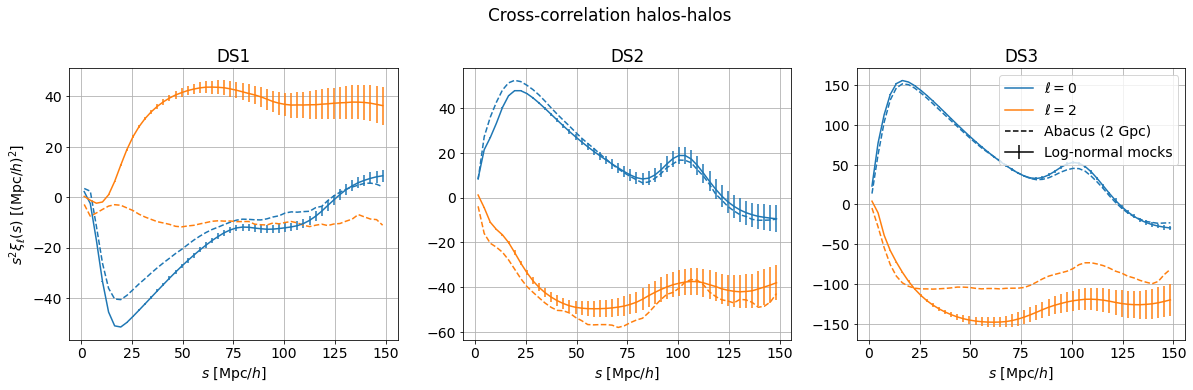

In [13]:
plt.rcParams["figure.figsize"] = (20, 5)
fig, axes = plt.subplots(1, 3, sharex=False, sharey=False)

for i in range(nsplits):
    for ill, ell in enumerate(ells):
        axes[i].plot(s, s**2 * abacus_split_xiell_hh[i][ill], linestyle = '--', color='C'+str(ill))
        axes[i].errorbar(s, s**2 * mocks_xiell_hh[i][ill], s**2 * std_hh[i][ill], fmt='-', color='C'+str(ill))
        
        axes[i].plot([],[], linestyle='-', color='C'+str(ill), label='$\ell = {:d}$'.format(ell))
        
        axes[i].grid(True)

        axes[i].set_title('DS{}'.format(i+1))    
        axes[i].set_xlabel(r'$s$ [$\mathrm{Mpc}/h$]')

axes[0].set_ylabel(r'$s^2 \xi_{\ell}(s)$ [$(\mathrm{Mpc}/h)^{2}$]')
axes[2].plot([],[], linestyle='--', color='black', label='Abacus (2 Gpc)')
axes[2].errorbar([],[],[], linestyle='-', color='black', label='Log-normal mocks')
axes[2].legend()

plt.suptitle('Cross-correlation halos-halos', y=1.05)
plt.show()

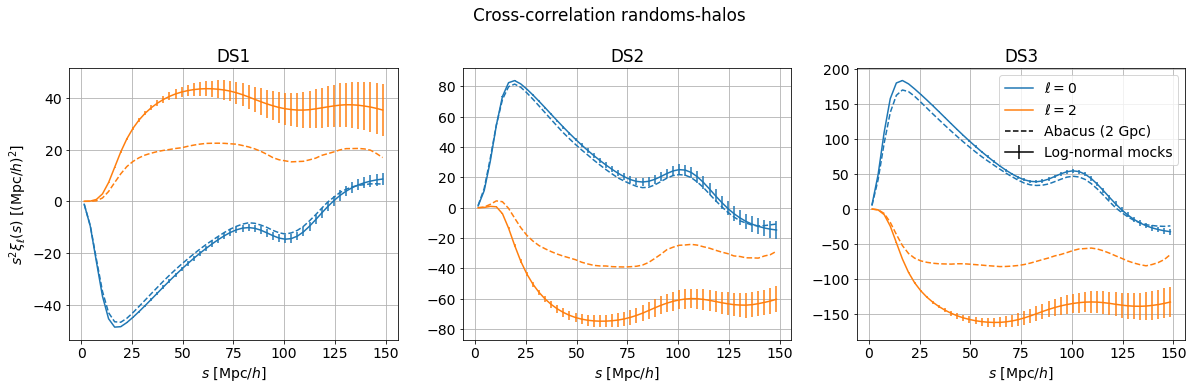

In [14]:
plt.rcParams["figure.figsize"] = (20, 5)
fig, axes = plt.subplots(1, 3, sharex=False, sharey=False)

for i in range(nsplits):
    for ill, ell in enumerate(ells):
        axes[i].plot(s, s**2 * abacus_split_xiell_rh[i][ill], linestyle = '--', color='C'+str(ill))
        axes[i].errorbar(s, s**2 * mocks_xiell_rh[i][ill], s**2 * std_rh[i][ill], fmt='-', color='C'+str(ill))
        
        axes[i].plot([],[], linestyle='-', color='C'+str(ill), label='$\ell = {:d}$'.format(ell))
        
        axes[i].grid(True)

        axes[i].set_title('DS{}'.format(i+1))    
        axes[i].set_xlabel(r'$s$ [$\mathrm{Mpc}/h$]')

axes[0].set_ylabel(r'$s^2 \xi_{\ell}(s)$ [$(\mathrm{Mpc}/h)^{2}$]')
axes[2].plot([],[], linestyle='--', color='black', label='Abacus (2 Gpc)')
axes[2].errorbar([],[],[], linestyle='-', color='black', label='Log-normal mocks')
axes[2].legend()

plt.suptitle('Cross-correlation randoms-halos', y=1.05)
plt.show()